# Method: Koopman Autoencoders
# Dataset: KS Equation, L = 60
# Purpose: Prediction

# 1. Set-up

In [1]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# Package
import sys
sys.path.append("../..")

In [2]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time, localtime, strftime

from functools import partial

import jax
from jax import jit, value_and_grad
import jax.numpy as jnp
from jax import random
from jax.example_libraries import optimizers
import jax.example_libraries.stax as stax
from jax.example_libraries.stax import Dense, Relu, Tanh
from jax.nn.initializers import glorot_normal

In [3]:
SEED = 42

In [4]:
train, test = load_data("KS, L = 60", "../../data/ks60", 0.5)

In [5]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (90000, 240)
Test size: (90000, 240)


**Create test set**

In [6]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [7]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 200 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [8]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 240)
Test output size: (100, 400, 240)


# 2. Koopman Autoencoder Implementation

In [9]:
def Dense_no_bias(out_dim, W_init = glorot_normal()):
    """Layer constructor function for a dense (fully-connected) layer."""
    def init_fun(rng, input_shape):
        output_shape = input_shape[:-1] + (out_dim,)
        k1, k2 = random.split(rng)
        W = W_init(k1, (input_shape[-1], out_dim))
        return output_shape, W
    def apply_fun(params, inputs, **kwargs):
        W = params
        return jnp.dot(inputs, W)
    return init_fun, apply_fun

In [10]:
def get_params(hidden_state_list, max_lag, lambda_list, seed, batch_size, num_epoch, lr_schedule, 
               early_stopping = EARLY_STOPPING):
    assert len(num_epoch) == len(lr_schedule)
    
    def create_network():
        encoder_init, encoder = stax.serial(
            Dense(p1), Tanh,  
            Dense(p2), Tanh,
            Dense(p3), Tanh,
            Dense(kappa))
        decoder_init, decoder = stax.serial(
            Dense(p3), Tanh,
            Dense(p2), Tanh,
            Dense(p1), Tanh,
            Dense(data_dim))
        forward_init, forward = stax.serial(
            Dense_no_bias(kappa))
        backward_init, backward = stax.serial(
            Dense_no_bias(kappa))

        # initialization
        enc_init_rng, dec_init_rng, forward_init_rng, backward_init_rng = random.split(key, num = 4)

        enc_in_shape = (-1, data_dim)
        dec_in_shape = (-1, kappa)
        forward_in_shape = (-1, kappa)
        backward_in_shape = (-1, kappa)
        _, enc_params = encoder_init(enc_init_rng, enc_in_shape)
        _, dec_params = decoder_init(dec_init_rng, dec_in_shape)
        _, fwd_params = forward_init(forward_init_rng, forward_in_shape)
        _, bwd_params = backward_init(backward_init_rng, backward_in_shape)

        network = (encoder, decoder, forward, backward)
        params = (enc_params, dec_params, fwd_params, bwd_params)
        return network, params
    
    def training(init_params):
        @jit
        def loss(params, batch):
            """
            each batch has dimension Batch_size x (max_lag+1) x dim
            """
            # unpack parameters
            enc_params, dec_params, fwd_params, bwd_params = params
            lambda_id, lambda_fwd, lambda_bwd, lambda_con = lambda_list

            loss_id, loss_fwd, loss_bwd, loss_con = 0, 0, 0, 0

            # AUTOENCODER
            f_start = batch[:,0,:]
            f_target = batch[:,0,:]
            f_encoded = encoder(enc_params, f_start)
            f_predict = decoder(dec_params, f_encoded)
            loss_id = 0.5 * jnp.mean((f_predict - f_target)**2)

            # FORWARD
            f_start = batch[:,0,:]
            f_encoded = encoder(enc_params, f_start)
            for t_steps in range(1, max_lag+ 1):
                # simulate forward
                f_encoded = forward(fwd_params, f_encoded)
                f_predict = decoder(dec_params, f_encoded)
                f_target = batch[:,t_steps,:]
                loss_fwd += 0.5 * jnp.mean((f_predict - f_target)**2)

            loss_fwd = loss_fwd / max_lag

            # BACKWARD
            f_start = batch[:,-1,:]
            f_encoded = encoder(enc_params, f_start)
            for t_steps in range(1, max_lag + 1):
                f_encoded = backward(bwd_params, f_encoded)
                f_predict = decoder(dec_params, f_encoded)
                f_target = batch[:,-t_steps-1,:]
                loss_bwd += 0.5 * jnp.mean((f_predict - f_target)**2)

            loss_bwd = loss_bwd / max_lag

            # CONSISTENT
            for k in range(1, kappa + 1):
                C_upper = fwd_params[0][:k, :]
                D_left = bwd_params[0][:, :k]
                C_left = fwd_params[0][:, :k]
                D_upper = bwd_params[0][:k, :]

                I_k = jnp.identity(k)

                loss_con += (jnp.sum((D_upper @ C_left - I_k)**2) + jnp.sum((C_upper @ D_left - I_k)**2)) / (2 * k)

            return lambda_id * loss_id + lambda_fwd * loss_fwd + lambda_bwd * loss_bwd + lambda_con * loss_con
    
        @jit
        def step(i, opt_state, batch):
            params = get_params(opt_state)
            value, g = value_and_grad(loss)(params, batch)
            opt_state = opt_update(i, g, opt_state)
            return get_params(opt_state), opt_state, value
        
        def make_forecast(params, batch, L_forecast):
            enc_params, dec_params, fwd_params, bwd_params = params

            preds = []
            f_start = batch[:, 0, :]
            f_encoded = encoder(enc_params, f_start)
            for t in range(L_forecast):
                f_encoded = forward(fwd_params, f_encoded)
                f_predict = decoder(dec_params, f_encoded)
                preds.append(f_predict)
            return np.swapaxes(preds, 0, 1)      
        
        def mse(params, x_batch, y_truth):
            """
            For each time-series in a batch, forecasts over a finite horizon 
            and compute the MSE. Primarily used for validation calculation

            args:
            ====
             params: neural parameters
             x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
             y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

            outputs:
            =======
             MSE: MSE between forecasts and targets
            """

            # horizon of the forecast
            L_forecast = y_truth.shape[1]    
            y_pred = make_forecast(params, x_batch, L_forecast_test)
            
            #compute MSE
            error = y_pred - y_truth
            mu_loss = np.mean(error**2)
            return mu_loss 
        
        start = time()
        best_params = init_params
        overall_best_mse = 99999999
        
        # train/val split
        t_size = int(0.9 * train_size)
        v_size = train_size - t_size
        T_indices_val = np.arange(t_size, train_size - (L_forecast_test + max_lag))
        t_start_val = T_indices_val[::10]
        t_past_batch_val = (t_start_val[:,None] + np.arange(max_lag)[None,:]).astype(int) 
        t_pred_batch_val = (t_start_val[:,None] + np.arange(max_lag, max_lag + L_forecast_test)[None,:]).astype(int) 
        x_val = x[t_past_batch_val]
        y_val = y[t_pred_batch_val]
        
        print("Backpropogation start", end = "\n\n")
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init(best_params)
            counter = 0
            best_mse = 999999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                # randomize the order of the data
                T_indices = np.arange(t_size - max_lag - 1)
                np.random.shuffle(T_indices)
                
                # training
                loss_epoch_train = []
                
                for k in range(t_size // batch_size + 1):
                    # create a batch of data
                    t_start = T_indices[np.arange(k*batch_size, (k+1)*batch_size).astype(int) % len(T_indices)] # start of each time series in the batch

                    # create 2d array of dimension (batch_size, max_lag + 1) containing all the time indices
                    t_batch = (t_start[:,None] + np.arange(max_lag + 1)[None,:]).astype(int) # transposes data

                    #create batch of dimension (batch_size,  max_lag + 1, data_dim)
                    x_batch = x[t_batch]  

                    params, opt_state, loss_current = step(k, opt_state, x_batch)
                    loss_epoch_train.append(loss_current.item())
                
                mse_train = np.mean(loss_epoch_train)

                # validation
                mse_val = mse(params, x_val, y_val)
                
                if best_mse > mse_val: # Improvement
                    counter = 0
                    best_mse = mse_val
                    best_params = params
                else:
                    counter += 1
                
                e_end = time()
                if (epoch + 1) % 10 == 0 or (counter == 0 and epoch >= 30):
                    print(f"Epoch {epoch + 1}: Time taken = {e_end - e_start:.2f} | Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                if counter >= early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                    break
            
            print(f"Best Validation MSE: {best_mse:.7f}")
            
            if best_mse < overall_best_mse: # Best round so far
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_mse
                overall_best_params = best_params
            print()
            
        end = time()
        print(f"Total time: {end - start:.2f}")

        return overall_best_params
            
    start = time()
    x, y = train.data[:-1], train.data[1:]
    train_size, data_dim = x.data.shape
    p1, p2, p3, kappa = hidden_state_list # 4 layers (including bottleneck)
        
    np.random.seed(seed)
    key = jax.random.PRNGKey(seed)
    
    (encoder, decoder, forward, backward), params = create_network()
    final_params = training(params)
    
    return final_params, (encoder, decoder, forward, backward)

In [21]:
def get_test_pred(data_test, params, network):
    start = time()
    
    (encoder, decoder, forward, backward) = network
    enc_params, dec_params, fwd_params, bwd_params = params
    
    num_data_test, L_past, data_dim = data_test.shape # testing ex, # steps used before, dim of data

    preds = []
    f_start = data_test[:, 0, :]
    f_encoded = encoder(enc_params, f_start)
    for t in range(L_forecast_test):
        f_encoded = forward(fwd_params, f_encoded)
        f_predict = decoder(dec_params, f_encoded)
        preds.append(f_predict)
    end = time()
    print(f"Time taken: {end - start:.2f}")
    return np.swapaxes(preds, 0, 1)

# 3. Parameter tuning

There are 3 parameters to tune
- hidden_size - size of the hidden layer
- max_lag - Number of steps calculated for forward and backward dynamics
- loss_weights - [encoder, forward, backward, consistent] loss

## 3.1 hidden_size

**Parameters**
- hidden_size varied
- max_lag = 8
- loss_weights = [1, 1, 0.1, 0.01]

In [12]:
max_lag = 8
loss_weights = [1, 1, .1, .01]

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

In [13]:
res_folder = os.path.join("results", "koopman")

### 3.1.1 hidden_size = [32, 16, 16, 8]

In [14]:
hidden_size = [32, 16, 16, 8]

In [15]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.17 | Train loss = 0.4245441 | Val loss =  1.3825630
Epoch 20: Time taken = 3.11 | Train loss = 0.3832758 | Val loss =  1.3341506
Epoch 30: Time taken = 3.21 | Train loss = 0.3302856 | Val loss =  1.5389562
EARLY STOPPING. Epoch 31: Train loss = 0.3285672 | Val loss =  1.6167242
Best Validation MSE: 0.9800169
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.21 | Train loss = 0.4115073 | Val loss =  1.4846558
Epoch 20: Time taken = 3.04 | Train loss = 0.3563435 | Val loss =  1.3438154
Epoch 30: Time taken = 3.62 | Train loss = 0.3210935 | Val loss =  1.6341730
EARLY STOPPING. Epoch 31: Train loss = 0.3188785 | Val loss =  1.5316735
Best Validation MSE: 0.9837736

Epoch 10: Time taken = 3.22 | Train loss = 0.4030989 | Val loss =  1.4161258
Epoch 20: Time taken = 3.58 | Train loss = 0.3441867 | Val loss =  1.3278831
Epoch 30: Time taken = 3.50 | Train loss = 0.3172427 | Val loss =  1.5391004
EARLY STOPPING. Epoch 32: Train loss = 0.3139317 |

In [16]:
mean_pred = get_test_pred(X_test, params, network)

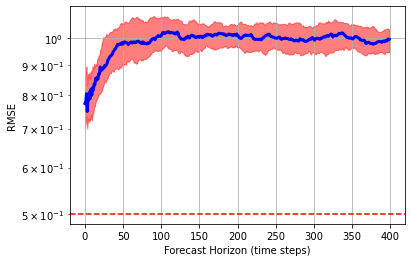

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 5: 0.893
Median NRMSE at t = 10: 0.959
Median NRMSE at t = 20: 0.980
Median NRMSE at t = 50: 1.012
Median NRMSE at t = 99: 0.989


In [17]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
print()
res_single.get_loss([5, 10, 20, 50, 99], dt = .25)

### 3.1.2 hidden_size = [16, 8, 8, 4]

In [18]:
hidden_size = [16, 8, 8, 4]

In [19]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.56 | Train loss = 0.7097032 | Val loss =  1.0744917
Epoch 20: Time taken = 3.57 | Train loss = 0.6518837 | Val loss =  1.1101157
Epoch 30: Time taken = 3.38 | Train loss = 0.6113208 | Val loss =  1.3309662
EARLY STOPPING. Epoch 31: Train loss = 0.6088455 | Val loss =  1.3748134
Best Validation MSE: 0.9801351
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.51 | Train loss = 0.7029788 | Val loss =  1.0387655
Epoch 20: Time taken = 3.57 | Train loss = 0.6463680 | Val loss =  1.1529464
Epoch 30: Time taken = 4.19 | Train loss = 0.6078620 | Val loss =  1.3716813
Epoch 40: Time taken = 3.38 | Train loss = 0.5908075 | Val loss =  1.4354652
EARLY STOPPING. Epoch 41: Train loss = 0.5899430 | Val loss =  1.4887088
Best Validation MSE: 1.0180387

Epoch 10: Time taken = 3.52 | Train loss = 0.6374207 | Val loss =  1.3441773
Epoch 20: Time taken = 3.34 | Train loss = 0.6038123 | Val loss =  1.3981445
Epoch 30: Time taken = 3.47 | Train loss = 0.59169

In [20]:
mean_pred = get_test_pred(X_test, params, network)

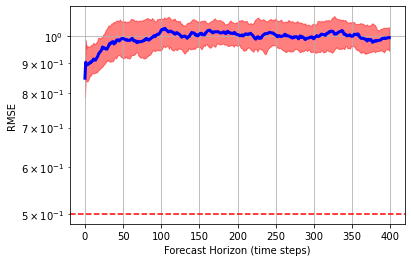

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 5: 0.941
Median NRMSE at t = 10: 0.974
Median NRMSE at t = 20: 0.990
Median NRMSE at t = 50: 1.006
Median NRMSE at t = 99: 0.993


In [21]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
print()
res_single.get_loss([5, 10, 20, 50, 99], dt = .25)

### 3.1.3 hidden_size = [64, 128, 128, 256]

In [13]:
hidden_size = [64, 128, 128, 256]

In [14]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 20.67 | Train loss = 0.0191260 | Val loss =  3.6373611
Epoch 20: Time taken = 19.76 | Train loss = 0.0105351 | Val loss =  3.6730029
Epoch 30: Time taken = 20.11 | Train loss = 0.0081624 | Val loss =  4.1087881
EARLY STOPPING. Epoch 32: Train loss = 0.0079354 | Val loss =  4.2781285
Best Validation MSE: 1.4822245
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 18.45 | Train loss = 0.0148416 | Val loss =  4.0340611
Epoch 20: Time taken = 16.08 | Train loss = 0.0096045 | Val loss =  3.3766947
Epoch 30: Time taken = 15.88 | Train loss = 0.0078857 | Val loss =  3.5829342
EARLY STOPPING. Epoch 31: Train loss = 0.0075997 | Val loss =  3.5713941
Best Validation MSE: 1.7581670

Epoch 10: Time taken = 18.34 | Train loss = 0.0132330 | Val loss =  3.9394951
Epoch 20: Time taken = 16.06 | Train loss = 0.0090803 | Val loss =  3.3268668
Epoch 30: Time taken = 18.69 | Train loss = 0.0075240 | Val loss =  4.0527775
EARLY STOPPING. Epoch 31: Train loss = 0.

In [15]:
mean_pred = get_test_pred(X_test, params, network)

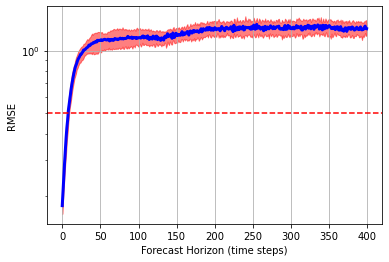

It takes around t = 0.08 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.894
Median NRMSE at t = 0.5: 1.122
Median NRMSE at t = 1: 1.151
Median NRMSE at t = 2: 1.288
Median NRMSE at t = 3: 1.284


In [16]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.4 hidden_size = [32, 24, 24, 16]

In [13]:
hidden_size = [32, 24, 24, 16]

In [14]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.91 | Train loss = 0.2893119 | Val loss =  1.3681645
Epoch 20: Time taken = 3.93 | Train loss = 0.2057277 | Val loss =  1.9579424
Epoch 30: Time taken = 3.94 | Train loss = 0.1896485 | Val loss =  2.0177862
EARLY STOPPING. Epoch 31: Train loss = 0.1888993 | Val loss =  1.9944608
Best Validation MSE: 0.9787702
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.73 | Train loss = 0.2521625 | Val loss =  1.3798469
Epoch 20: Time taken = 3.89 | Train loss = 0.1981171 | Val loss =  1.9542676
Epoch 30: Time taken = 3.66 | Train loss = 0.1881664 | Val loss =  2.0759687
EARLY STOPPING. Epoch 34: Train loss = 0.1860898 | Val loss =  2.0913094
Best Validation MSE: 1.0353295

Epoch 10: Time taken = 3.96 | Train loss = 0.2114067 | Val loss =  1.8028545
Epoch 20: Time taken = 3.94 | Train loss = 0.1915690 | Val loss =  2.1638787
Epoch 30: Time taken = 3.83 | Train loss = 0.1852513 | Val loss =  2.0710120
EARLY STOPPING. Epoch 31: Train loss = 0.1847005 |

In [15]:
mean_pred = get_test_pred(X_test, params, network)

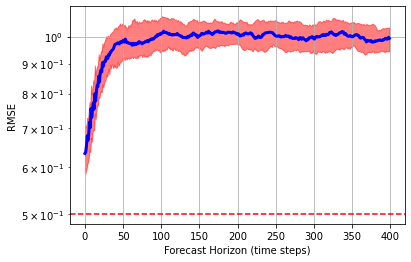

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.867
Median NRMSE at t = 0.5: 0.985
Median NRMSE at t = 1: 1.010
Median NRMSE at t = 2: 1.012
Median NRMSE at t = 3: 0.991


In [16]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.5 hidden_size = [36, 32, 32, 24]

In [17]:
hidden_size = [36, 32, 32, 24]

In [18]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.89 | Train loss = 0.2042108 | Val loss =  1.5238437
Epoch 20: Time taken = 4.16 | Train loss = 0.1426612 | Val loss =  1.9702600
Epoch 30: Time taken = 4.31 | Train loss = 0.1098073 | Val loss =  2.7585003
EARLY STOPPING. Epoch 31: Train loss = 0.1082148 | Val loss =  2.3005242
Best Validation MSE: 0.9881254
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 4.10 | Train loss = 0.1889239 | Val loss =  1.9449251
Epoch 20: Time taken = 4.04 | Train loss = 0.1383186 | Val loss =  2.1153094
Epoch 30: Time taken = 3.99 | Train loss = 0.1264792 | Val loss =  2.3840180
EARLY STOPPING. Epoch 32: Train loss = 0.1248143 | Val loss =  2.5965066
Best Validation MSE: 1.0106572

Epoch 10: Time taken = 3.70 | Train loss = 0.1687800 | Val loss =  1.5368499
Epoch 20: Time taken = 3.68 | Train loss = 0.1336059 | Val loss =  2.4861085
Epoch 30: Time taken = 3.62 | Train loss = 0.1233784 | Val loss =  2.4833376
EARLY STOPPING. Epoch 32: Train loss = 0.1219311 |

In [19]:
mean_pred = get_test_pred(X_test, params, network)

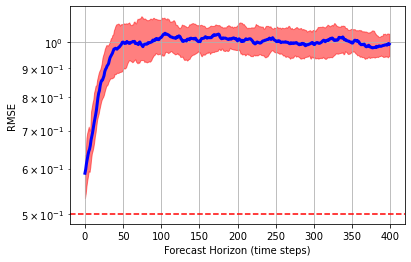

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.840
Median NRMSE at t = 0.5: 1.001
Median NRMSE at t = 1: 1.019
Median NRMSE at t = 2: 1.005
Median NRMSE at t = 3: 0.991


In [20]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.6 hidden_size = [40, 40, 40, 40]

In [22]:
hidden_size = [40, 40, 40, 40]

In [23]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 4.57 | Train loss = 0.1423187 | Val loss =  2.0464066
Epoch 20: Time taken = 4.69 | Train loss = 0.0986971 | Val loss =  2.4084184
Epoch 30: Time taken = 4.82 | Train loss = 0.0871706 | Val loss =  2.9284634
EARLY STOPPING. Epoch 31: Train loss = 0.0865767 | Val loss =  3.0022463
Best Validation MSE: 0.9950483
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 4.61 | Train loss = 0.1266649 | Val loss =  2.3267249
Epoch 20: Time taken = 4.48 | Train loss = 0.0954536 | Val loss =  2.6114197
Epoch 30: Time taken = 4.55 | Train loss = 0.0864946 | Val loss =  3.0403917
EARLY STOPPING. Epoch 31: Train loss = 0.0860071 | Val loss =  3.2986699
Best Validation MSE: 1.0079598

Epoch 10: Time taken = 4.43 | Train loss = 0.1183765 | Val loss =  2.1093723
Epoch 20: Time taken = 4.45 | Train loss = 0.0921365 | Val loss =  2.7529707
Epoch 30: Time taken = 4.50 | Train loss = 0.0853037 | Val loss =  3.1565166
EARLY STOPPING. Epoch 31: Train loss = 0.0849051 |

In [24]:
mean_pred = get_test_pred(X_test, params, network)

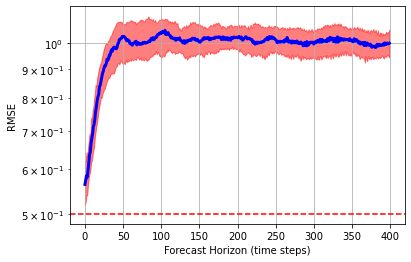

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.843
Median NRMSE at t = 0.5: 1.027
Median NRMSE at t = 1: 1.040
Median NRMSE at t = 2: 1.022
Median NRMSE at t = 3: 0.996


In [25]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.2 max_lag

In [27]:
loss_weights = [1, 1, .1, .01]
hidden_size = [36, 32, 32, 24]

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

### 3.2.1 max_lag = 4

In [28]:
max_lag = 4

In [29]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 4.11 | Train loss = 0.1646435 | Val loss =  2.8861510
Epoch 20: Time taken = 3.59 | Train loss = 0.1282164 | Val loss =  3.4854795
Epoch 30: Time taken = 3.60 | Train loss = 0.0964241 | Val loss =  3.9121172
EARLY STOPPING. Epoch 31: Train loss = 0.0952107 | Val loss =  3.9582322
Best Validation MSE: 1.0346310
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.70 | Train loss = 0.1383051 | Val loss =  2.7493991
Epoch 20: Time taken = 3.70 | Train loss = 0.1053197 | Val loss =  3.5777284
Epoch 30: Time taken = 4.20 | Train loss = 0.0900987 | Val loss =  4.1453903
EARLY STOPPING. Epoch 31: Train loss = 0.0894127 | Val loss =  4.1271537
Best Validation MSE: 1.1874893

Epoch 10: Time taken = 4.05 | Train loss = 0.1313412 | Val loss =  3.0629798
Epoch 20: Time taken = 3.89 | Train loss = 0.0965981 | Val loss =  3.5843866
Epoch 30: Time taken = 3.56 | Train loss = 0.0789784 | Val loss =  4.8657064
EARLY STOPPING. Epoch 31: Train loss = 0.0782227 |

In [30]:
mean_pred = get_test_pred(X_test, params, network)

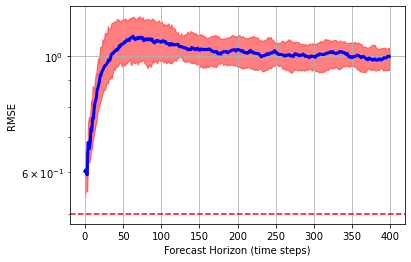

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.921
Median NRMSE at t = 0.5: 1.054
Median NRMSE at t = 1: 1.063
Median NRMSE at t = 2: 1.030
Median NRMSE at t = 3: 0.999


In [31]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.2 max_lag = 8
This is already done in 3.1.5

### 3.2.3 max_lag = 16

In [32]:
max_lag = 16

In [33]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 6.47 | Train loss = 0.2680602 | Val loss =  1.0399408
Epoch 20: Time taken = 6.04 | Train loss = 0.2205663 | Val loss =  1.2572116
Epoch 30: Time taken = 5.75 | Train loss = 0.1998997 | Val loss =  1.9504091
EARLY STOPPING. Epoch 31: Train loss = 0.1984296 | Val loss =  1.7359379
Best Validation MSE: 0.9886703
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 5.85 | Train loss = 0.2565031 | Val loss =  1.1281637
Epoch 20: Time taken = 5.76 | Train loss = 0.2161256 | Val loss =  1.3415499
Epoch 30: Time taken = 6.00 | Train loss = 0.1960178 | Val loss =  1.9119287
EARLY STOPPING. Epoch 31: Train loss = 0.1945024 | Val loss =  2.0037366
Best Validation MSE: 0.9922848

Epoch 10: Time taken = 5.45 | Train loss = 0.2462482 | Val loss =  1.1266655
Epoch 20: Time taken = 4.68 | Train loss = 0.2097364 | Val loss =  1.5848243
Epoch 30: Time taken = 4.51 | Train loss = 0.1922894 | Val loss =  2.0064931
EARLY STOPPING. Epoch 31: Train loss = 0.1890337 |

In [34]:
mean_pred = get_test_pred(X_test, params, network)

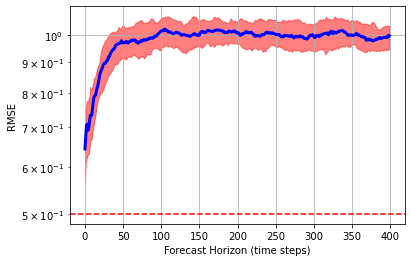

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.864
Median NRMSE at t = 0.5: 0.971
Median NRMSE at t = 1: 1.017
Median NRMSE at t = 2: 1.010
Median NRMSE at t = 3: 0.996


In [35]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.4 max_lag = 24

In [18]:
max_lag = 24

In [19]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 7.35 | Train loss = 0.3333475 | Val loss =  1.0140230
Epoch 20: Time taken = 8.33 | Train loss = 0.2774391 | Val loss =  1.0488320
Epoch 30: Time taken = 7.60 | Train loss = 0.2563679 | Val loss =  1.0522538
EARLY STOPPING. Epoch 31: Train loss = 0.2550559 | Val loss =  1.0704779
Best Validation MSE: 0.9945498
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 7.18 | Train loss = 0.3169238 | Val loss =  1.0236495
Epoch 20: Time taken = 7.44 | Train loss = 0.2749787 | Val loss =  1.0468470
Epoch 30: Time taken = 8.13 | Train loss = 0.2547177 | Val loss =  1.0511996
EARLY STOPPING. Epoch 32: Train loss = 0.2517407 | Val loss =  1.0761690
Best Validation MSE: 1.0011638

Epoch 10: Time taken = 8.16 | Train loss = 0.2998343 | Val loss =  1.0301901
Epoch 20: Time taken = 7.44 | Train loss = 0.2660204 | Val loss =  1.0501302
Epoch 30: Time taken = 7.64 | Train loss = 0.2482472 | Val loss =  1.0641045
EARLY STOPPING. Epoch 31: Train loss = 0.2465706 |

In [20]:
mean_pred = get_test_pred(X_test, params, network)

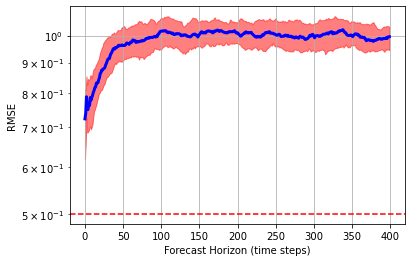

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.863
Median NRMSE at t = 0.5: 0.962
Median NRMSE at t = 1: 1.017
Median NRMSE at t = 2: 1.011
Median NRMSE at t = 3: 0.998


In [21]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.5 max_lag = 32

In [23]:
max_lag = 32

In [24]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 8.34 | Train loss = 0.3927364 | Val loss =  1.0105063
Epoch 20: Time taken = 8.67 | Train loss = 0.3347499 | Val loss =  1.0313385
Epoch 30: Time taken = 8.51 | Train loss = 0.3107651 | Val loss =  1.0312686
EARLY STOPPING. Epoch 31: Train loss = 0.3092669 | Val loss =  1.0253926
Best Validation MSE: 0.9981960
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 8.20 | Train loss = 0.3776050 | Val loss =  1.0136419
Epoch 20: Time taken = 8.63 | Train loss = 0.3259986 | Val loss =  1.0253238
Epoch 30: Time taken = 8.23 | Train loss = 0.3093667 | Val loss =  1.0285439
EARLY STOPPING. Epoch 31: Train loss = 0.3083020 | Val loss =  1.0241709
Best Validation MSE: 1.0028697

Epoch 10: Time taken = 8.05 | Train loss = 0.3644637 | Val loss =  1.0153406
Epoch 20: Time taken = 8.63 | Train loss = 0.3234852 | Val loss =  1.0237138
Epoch 30: Time taken = 8.04 | Train loss = 0.3084497 | Val loss =  1.0210224
EARLY STOPPING. Epoch 33: Train loss = 0.3056161 |

In [25]:
mean_pred = get_test_pred(X_test, params, network)

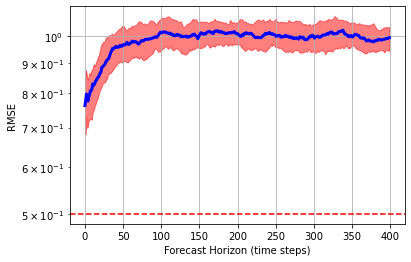

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.867
Median NRMSE at t = 0.5: 0.967
Median NRMSE at t = 1: 1.014
Median NRMSE at t = 2: 1.011
Median NRMSE at t = 3: 0.996


In [26]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.3 Loss coefficients

In [37]:
hidden_size = [36, 32, 32, 24]
max_lag = 8

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

### 3.3.1 Base [1, 1, 0.1, 0.01]
This is done in 3.1.5/3.2.2

### 3.3.2 Increased focus on forward loss [1, 2, 0.1, 0.01]

In [38]:
loss_weights = [1, 2, .1, .01]

In [39]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.65 | Train loss = 0.3181165 | Val loss =  1.8332529
Epoch 20: Time taken = 4.56 | Train loss = 0.2412981 | Val loss =  1.9674429
Epoch 30: Time taken = 4.53 | Train loss = 0.2255605 | Val loss =  2.0876759
EARLY STOPPING. Epoch 31: Train loss = 0.2243916 | Val loss =  2.1879116
Best Validation MSE: 1.0014687
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 4.73 | Train loss = 0.2912042 | Val loss =  1.8921386
Epoch 20: Time taken = 4.57 | Train loss = 0.2370054 | Val loss =  1.8530400
Epoch 30: Time taken = 4.61 | Train loss = 0.2229386 | Val loss =  2.2017941
EARLY STOPPING. Epoch 32: Train loss = 0.2206550 | Val loss =  2.2976964
Best Validation MSE: 1.0117583

Epoch 10: Time taken = 4.79 | Train loss = 0.2563912 | Val loss =  1.6043276
Epoch 20: Time taken = 5.07 | Train loss = 0.2321582 | Val loss =  2.1132073
Epoch 30: Time taken = 4.59 | Train loss = 0.2176496 | Val loss =  2.4121985
EARLY STOPPING. Epoch 31: Train loss = 0.2162857 |

In [40]:
mean_pred = get_test_pred(X_test, params, network)

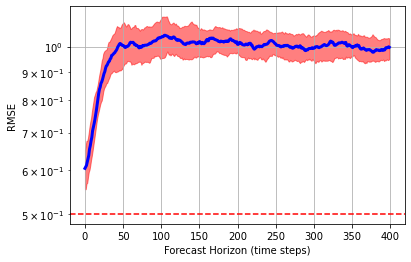

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.846
Median NRMSE at t = 0.5: 1.005
Median NRMSE at t = 1: 1.040
Median NRMSE at t = 2: 1.010
Median NRMSE at t = 3: 0.993


In [41]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.3.3 Only autoencoder and forward loss [1, 1, 0, 0]

In [22]:
loss_weights = [1, 1, 0, 0]

In [23]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 7.16 | Train loss = 0.2882963 | Val loss =  1.0210829
Epoch 20: Time taken = 7.90 | Train loss = 0.2382294 | Val loss =  1.0563997
Epoch 30: Time taken = 7.31 | Train loss = 0.2171542 | Val loss =  1.0524737
EARLY STOPPING. Epoch 31: Train loss = 0.2153667 | Val loss =  1.0590607
Best Validation MSE: 0.9958191
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 7.45 | Train loss = 0.2750511 | Val loss =  1.0325751
Epoch 20: Time taken = 7.12 | Train loss = 0.2321729 | Val loss =  1.0498153
Epoch 30: Time taken = 7.52 | Train loss = 0.2132923 | Val loss =  1.0882542
EARLY STOPPING. Epoch 31: Train loss = 0.2117700 | Val loss =  1.0574099
Best Validation MSE: 0.9995643

Epoch 10: Time taken = 7.59 | Train loss = 0.2616790 | Val loss =  1.0424939
Epoch 20: Time taken = 7.30 | Train loss = 0.2279066 | Val loss =  1.0610599
Epoch 30: Time taken = 8.07 | Train loss = 0.2102294 | Val loss =  1.0744506
EARLY STOPPING. Epoch 31: Train loss = 0.2084876 |

In [24]:
mean_pred = get_test_pred(X_test, params, network)

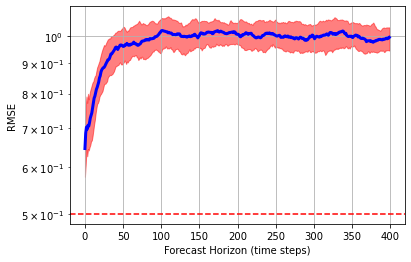

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.857
Median NRMSE at t = 0.5: 0.962
Median NRMSE at t = 1: 1.022
Median NRMSE at t = 2: 1.009
Median NRMSE at t = 3: 0.997


In [25]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.3.4 Equal weightage to forward and backward dynamic [1, 0.5, 0.5, 0.01]

In [28]:
loss_weights = [1, 0.5, 0.5, 0.01]

In [29]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 4.06 | Train loss = 0.2049079 | Val loss =  2.6785932
Epoch 20: Time taken = 4.00 | Train loss = 0.1756645 | Val loss =  4.0248419
Epoch 30: Time taken = 4.27 | Train loss = 0.1561843 | Val loss =  5.1706678
EARLY STOPPING. Epoch 33: Train loss = 0.1534691 | Val loss =  5.6372706
Best Validation MSE: 1.0064542
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 4.15 | Train loss = 0.1891226 | Val loss =  1.2820725
Epoch 20: Time taken = 3.98 | Train loss = 0.1612435 | Val loss =  1.6019876
Epoch 30: Time taken = 4.28 | Train loss = 0.1507966 | Val loss =  2.0186982
Epoch 40: Time taken = 3.97 | Train loss = 0.1245308 | Val loss =  2.4077552
EARLY STOPPING. Epoch 40: Train loss = 0.1245308 | Val loss =  2.4077552
Best Validation MSE: 1.2820725

Epoch 10: Time taken = 4.33 | Train loss = 0.1598831 | Val loss =  1.7619162
Epoch 20: Time taken = 4.04 | Train loss = 0.1487588 | Val loss =  1.8111405
Epoch 30: Time taken = 4.06 | Train loss = 0.12344

In [30]:
mean_pred = get_test_pred(X_test, params, network)

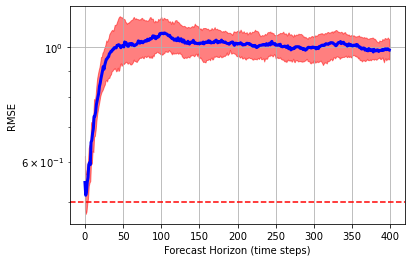

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.851
Median NRMSE at t = 0.5: 1.003
Median NRMSE at t = 1: 1.065
Median NRMSE at t = 2: 1.014
Median NRMSE at t = 3: 1.000


In [31]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.3.5 Increased and Equal weightage to forward and backward dynamic [1, 1, 1, 0.01]

In [42]:
loss_weights = [1, 1, 1, 0.01]

In [43]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 4.28 | Train loss = 0.3381619 | Val loss =  2.1706243
Epoch 20: Time taken = 4.17 | Train loss = 0.2770105 | Val loss =  1.9831376
Epoch 30: Time taken = 4.25 | Train loss = 0.2643694 | Val loss =  2.7608897
EARLY STOPPING. Epoch 32: Train loss = 0.2629569 | Val loss =  3.4166163
Best Validation MSE: 0.9996967
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 4.44 | Train loss = 0.3145435 | Val loss =  1.2815684
Epoch 20: Time taken = 4.53 | Train loss = 0.2703266 | Val loss =  4.7518203
Epoch 30: Time taken = 4.22 | Train loss = 0.2502066 | Val loss =  4.9646663
Epoch 40: Time taken = 4.14 | Train loss = 0.2122832 | Val loss =  2.1386825
EARLY STOPPING. Epoch 43: Train loss = 0.2092765 | Val loss =  1.7767805
Best Validation MSE: 1.1611689

Epoch 10: Time taken = 3.37 | Train loss = 0.2654429 | Val loss =  5.3530116
Epoch 20: Time taken = 3.40 | Train loss = 0.2243338 | Val loss =  3.1858599
Epoch 30: Time taken = 3.63 | Train loss = 0.20809

In [44]:
mean_pred = get_test_pred(X_test, params, network)

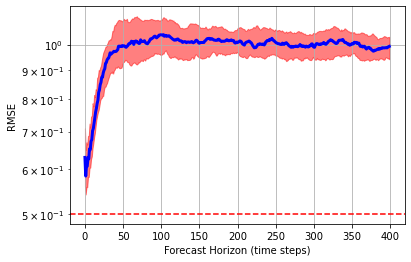

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.849
Median NRMSE at t = 0.5: 0.995
Median NRMSE at t = 1: 1.041
Median NRMSE at t = 2: 1.008
Median NRMSE at t = 3: 0.990


In [45]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 4. Final Model

In [46]:
hidden_size = [36, 32, 32, 24]
max_lag = 8
loss_weights = [1, 2, .1, .01]

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

In [47]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 3.51 | Train loss = 0.3181165 | Val loss =  1.8332529
Epoch 20: Time taken = 3.38 | Train loss = 0.2412981 | Val loss =  1.9674429
Epoch 30: Time taken = 3.57 | Train loss = 0.2255605 | Val loss =  2.0876759
EARLY STOPPING. Epoch 31: Train loss = 0.2243916 | Val loss =  2.1879116
Best Validation MSE: 1.0014687
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 3.39 | Train loss = 0.2912042 | Val loss =  1.8921386
Epoch 20: Time taken = 3.40 | Train loss = 0.2370054 | Val loss =  1.8530400
Epoch 30: Time taken = 3.46 | Train loss = 0.2229386 | Val loss =  2.2017941
EARLY STOPPING. Epoch 32: Train loss = 0.2206550 | Val loss =  2.2976964
Best Validation MSE: 1.0117583

Epoch 10: Time taken = 4.06 | Train loss = 0.2563912 | Val loss =  1.6043276
Epoch 20: Time taken = 4.36 | Train loss = 0.2321582 | Val loss =  2.1132073
Epoch 30: Time taken = 5.93 | Train loss = 0.2176496 | Val loss =  2.4121985
EARLY STOPPING. Epoch 31: Train loss = 0.2162857 |

In [48]:
mean_pred = get_test_pred(X_test, params, network)

In [49]:
save_obj(params, res_folder, "best_params.pkl")

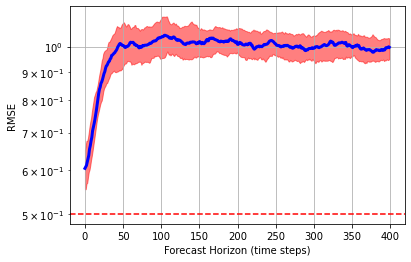

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 0.2: 0.846
Median NRMSE at t = 0.5: 1.005
Median NRMSE at t = 1: 1.040
Median NRMSE at t = 2: 1.010
Median NRMSE at t = 3: 0.993


In [50]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 5. Plot images based on Lyapunov Time

In [12]:
hidden_size = [36, 32, 32, 24]

In [13]:
res_folder = os.path.join("results", "koopman")

In [14]:
def create_network(hidden_size):
    p1, p2, p3, kappa = hidden_size
    encoder_init, encoder = stax.serial(
        Dense(p1), Tanh,  
        Dense(p2), Tanh,
        Dense(p3), Tanh,
        Dense(kappa))
    decoder_init, decoder = stax.serial(
        Dense(p3), Tanh,
        Dense(p2), Tanh,
        Dense(p1), Tanh,
        Dense(data_dim))
    forward_init, forward = stax.serial(
        Dense_no_bias(kappa))
    backward_init, backward = stax.serial(
        Dense_no_bias(kappa))
    network = (encoder, decoder, forward, backward)
    return network

In [15]:
network = create_network(hidden_size)
params = load_obj(os.path.join(res_folder, "best_params.pkl"))

In [22]:
mean_pred = get_test_pred(X_test, params, network)

Time taken: 0.40


In [17]:
save_obj(mean_pred, "results", "koopman_pred.pkl")

In [18]:
total_lyapunov_time_pred = 100 / KS_LT # Amount of Lyapunov Time in Test set

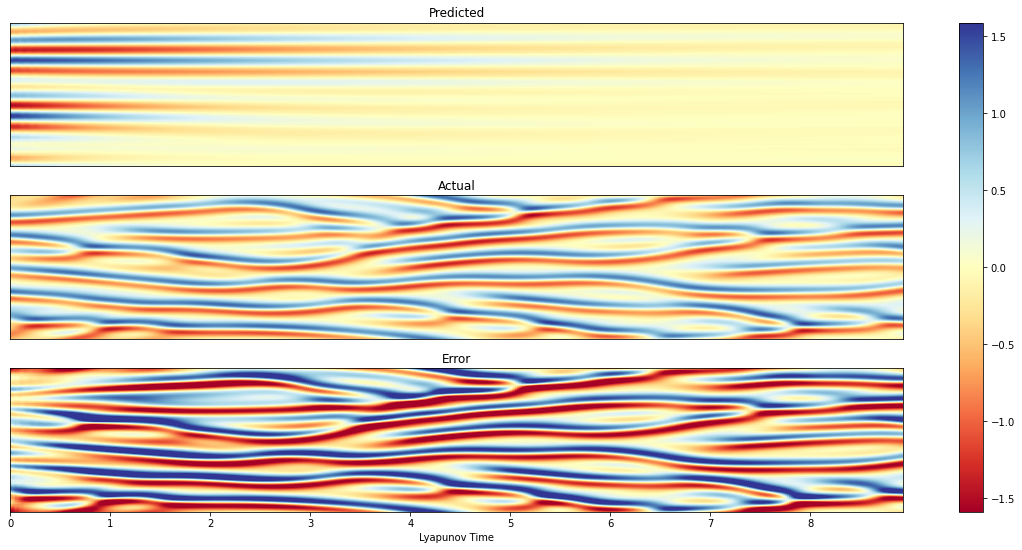

In [19]:
plot_predictions(mean_pred, y_test, total_lyapunov_time_pred, save_name = "Figure3-7b_Koopman_Prediction_Diagram")

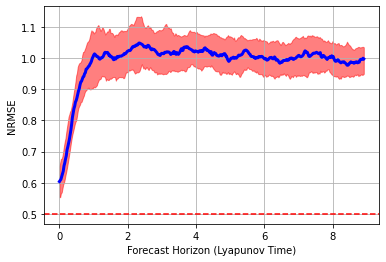

It takes around 0.00 Lyapunov Time for mean error to exceed 0.5

Median NRMSE at 0.5 Lyapunov Time: 0.864
Median NRMSE at 1.0 Lyapunov Time: 1.004
Median NRMSE at 2.0 Lyapunov Time: 1.022
Median NRMSE at 5.0 Lyapunov Time: 0.996


In [20]:
res_single = PointExperimentResultLyapunov(mean_pred - y_test, "ks")
res_single.plot_rmse(save_name = "Figure3-8b_Koopman_Prediction_Horizon")
print()
res_single.get_loss()